In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

df_filled = pd.read_csv("../preprocessing/train_cleaned.csv")
target = 'SalePrice'
cols_to_exclude = [target, "Id"]
features = [col for col in df_filled.select_dtypes(include=[np.number]).columns 
            if col not in cols_to_exclude]
X = df_filled[features]
y = df_filled[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
def evaluate_model(y_acc, y_pred):
    mae = mean_absolute_error(y_acc, y_pred)
    mse = mean_squared_error(y_acc, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_acc, y_pred)
    mape = np.mean(np.abs((y_acc - y_pred) / y_acc)) * 100
    rmse_pct = (rmse / y_acc.mean()) * 100
    return {
        'R²': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'RMSE%': rmse_pct
    }

In [20]:
def plot_ablation_changes(results_df, ablation_type):
    baseline_value = 0.914437
    
    pct_changes = (results_df['R²'] - baseline_value) * 100
    
    mask = ~results_df.index.str.startswith('Baseline')
    pct_changes = pct_changes[mask]
    
    pct_changes = pct_changes.sort_values()
    
    plt.figure(figsize=(16, 9))
    bars = plt.barh(range(len(pct_changes)), pct_changes.values, 
                    color='red', 
                    alpha=0.7)
    
    plt.yticks(range(len(pct_changes)), pct_changes.index, fontsize=10)
    plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
    plt.xlabel('% Change from Baseline', fontsize=12)
    plt.title(f'R² Changes from Baseline: {ablation_type}', 
              fontsize=14, fontweight='bold', pad=20)
    plt.grid(axis='x', alpha=0.3)
    
    for i, value in enumerate(pct_changes.values):
        label_x = value
        plt.text(label_x, i, f'{value:+.1f}%', 
                va='center', ha='left' if value > 0 else 'right',
                fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    
    return pct_changes

In [21]:
def ablation_study_xgb(X_train, X_test, y_train, y_test):
    results = {}
    best_params = {
        'learning_rate': 0.07001802283701665, 
        'max_depth': 3, 
        'n_estimators': 841}
    print("Training optimized baseline model...")
    xgb = XGBRegressor(random_state=42, 
                       learning_rate=best_params["learning_rate"], 
                       max_depth=best_params["max_depth"], 
                       n_estimators=best_params["n_estimators"])
    xgb.fit(X_train, y_train)
    y_xgb_pred = xgb.predict(X_test)
    results['Baseline (Full Optimized)'] = evaluate_model(y_test, y_xgb_pred)
    print("\nTesting learning rate variations...")
    learning_rates = [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 1]
    for rate in learning_rates:
        xgb = XGBRegressor(random_state=42,
                           learning_rate=rate,
                           max_depth=best_params["max_depth"], 
                           n_estimators=best_params["n_estimators"])
        xgb.fit(X_train, y_train)
        y_xgb_pred = xgb.predict(X_test)
        results[f'Learning Rate={rate}'] = evaluate_model(y_test, y_xgb_pred)
    print("\nTesting maximum depth variations...")
    depths = [2, 4, 5, 6, 8, 10]
    for depth in depths:
        xgb = XGBRegressor(random_state=42,
                           learning_rate=best_params["learning_rate"], 
                           max_depth=depth, 
                           n_estimators=best_params["n_estimators"])
        xgb.fit(X_train, y_train)
        y_xgb_pred = xgb.predict(X_test)
        results[f'Max Depth={depth}'] = evaluate_model(y_test, y_xgb_pred)
    print("\nTesting number of estimators variations...")
    num_estims = [100, 300, 500, 700, 1000, 1500]
    for n_e in num_estims:
        xgb = XGBRegressor(random_state=42,
                           learning_rate=best_params["learning_rate"], 
                           max_depth=best_params["max_depth"], 
                           n_estimators=n_e)
        xgb.fit(X_train, y_train)
        y_xgb_pred = xgb.predict(X_test)
        results[f'Number of Estimators={n_e}'] = evaluate_model(y_test, y_xgb_pred)
    print("\nTesting with StandardScaler...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    xgb = XGBRegressor(random_state=42, 
                       learning_rate=best_params["learning_rate"], 
                       max_depth=best_params["max_depth"], 
                       n_estimators=best_params["n_estimators"])
    xgb.fit(X_train_scaled, y_train)
    y_xgb_pred = xgb.predict(X_test_scaled)
    results['With StandardScaler'] = evaluate_model(y_test, y_xgb_pred)
    print("\nTesting vanilla model (all default hyperparameters)...")
    xgb = XGBRegressor(random_state=42)
    xgb.fit(X_train, y_train)
    y_xgb_pred = xgb.predict(X_test)
    results[f'Vanilla Model'] = evaluate_model(y_test, y_xgb_pred)
    return results

In [22]:
results = ablation_study_xgb(X_train, X_test, y_train, y_test)
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('R²', ascending=False)
results_df

Training optimized baseline model...

Testing learning rate variations...

Testing maximum depth variations...

Testing number of estimators variations...

Testing with StandardScaler...

Testing vanilla model (all default hyperparameters)...


,R²,RMSE,MAE,MAPE,RMSE%
Max Depth=5,0.921219,24581.982345,15512.113281,9.597627,13.745252
Max Depth=6,0.918775,24960.337177,15475.857422,9.481703,13.956812
Learning Rate=0.05,0.916152,25360.244794,15609.916016,9.331719,14.180425
Max Depth=4,0.914925,25545.108651,15818.157227,9.716970,14.283793
Number of Estimators=700,0.914584,25596.229722,15893.061523,9.653429,14.312378
Number of Estimators=1000,0.914492,25610.054276,15858.352539,9.645399,14.320108
Baseline (Full Optimized),0.914437,25618.202279,15871.274414,9.635575,14.324664
With StandardScaler,0.914437,25618.202279,15871.274414,9.635575,14.324664
Learning Rate=0.1,0.913909,25697.180546,15724.777344,9.468660,14.368826
Number of Estimators=1500,0.913607,25742.274647,15923.825195,9.710777,14.394040


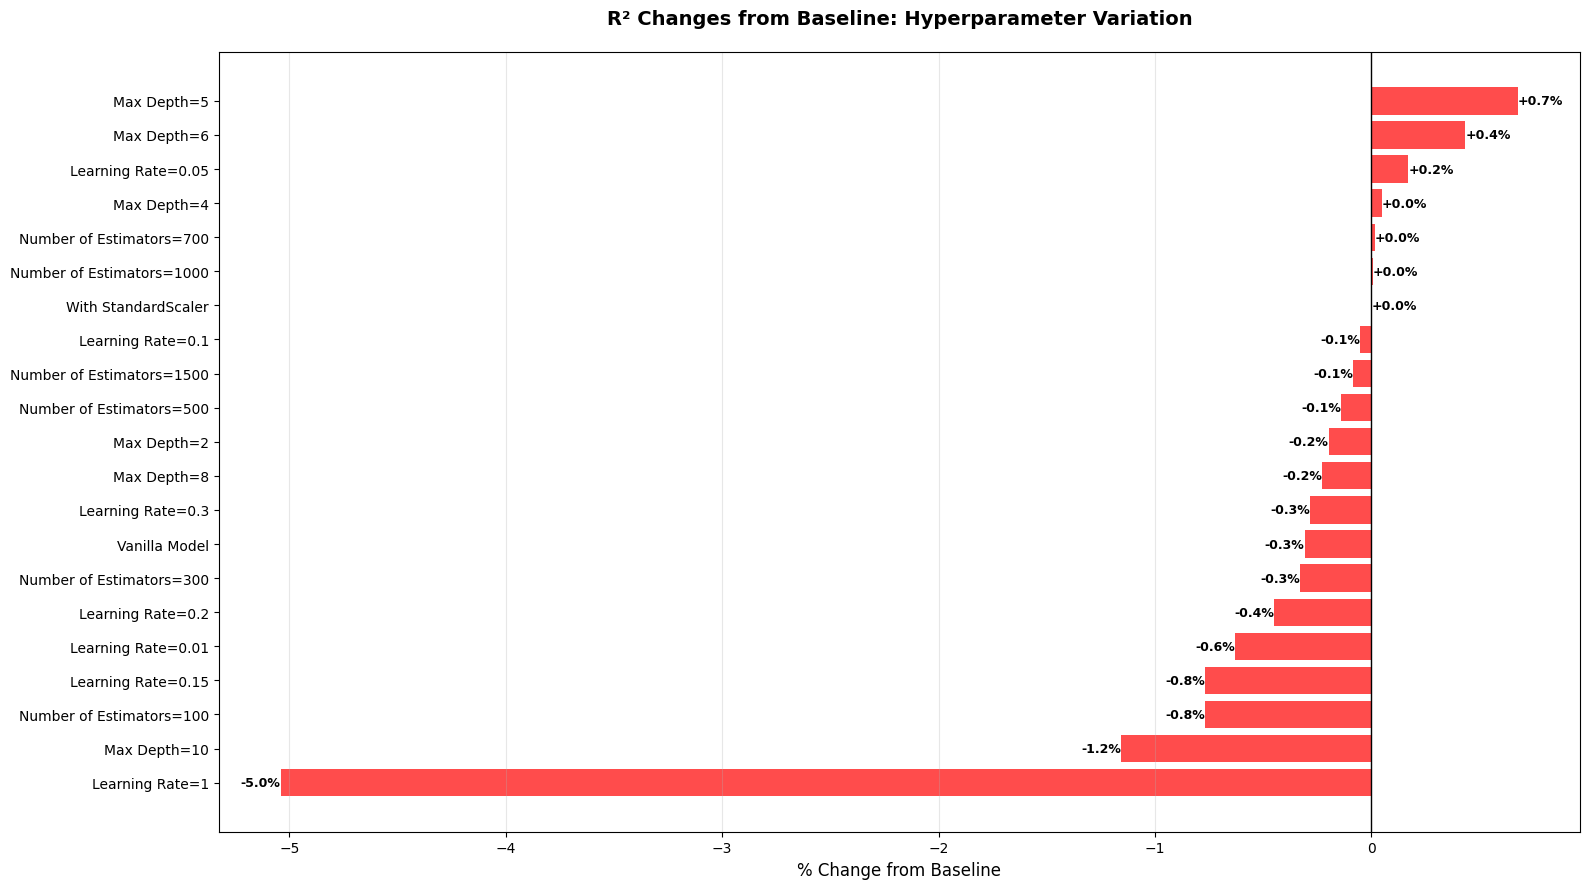

In [23]:
pct_changes_df = plot_ablation_changes(results_df, "Hyperparameter Variation")
plt.show()

In [24]:
def get_feature_categories(all_features):
    categories = {}
    
    categories['Property Basics'] = [
        'MSSubClass', 'LotFrontage', 'LotArea', 'LotShape', 'Utilities', 'LandSlope'
    ]
    
    location_prefixes = ['MSZoning_', 'Street_', 'LandContour_', 'LotConfig_', 
                        'Neighborhood_', 'Condition1_', 'Condition2_']
    categories['Location'] = [f for f in all_features if any(f.startswith(p) for p in location_prefixes)]
    
    building_prefixes = ['BldgType_', 'HouseStyle_', 'RoofStyle_', 'RoofMatl_']
    categories['Building Type & Style'] = [f for f in all_features if any(f.startswith(p) for p in building_prefixes)]
    
    exterior_prefixes = ['Exterior1st_', 'Exterior2nd_', 'MasVnrType_']
    categories['Exterior'] = [f for f in all_features if any(f.startswith(p) for p in exterior_prefixes)] + ['MasVnrArea']
    
    foundation_heating_prefixes = ['Foundation_', 'Heating_']
    categories['Foundation, Heating & Electrical'] = [f for f in all_features if any(f.startswith(p) for p in foundation_heating_prefixes)] + ['CentralAir', 'Electrical']
    
    categories['Quality & Condition Ratings'] = [
        'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'KitchenQual', 'Functional'
    ]
    
    categories['Age & Remodeling'] = ['YearBuilt', 'YearRemodAdd']
    
    categories['Basement'] = [
        'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
        'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF'
    ]
    
    categories['Living Space & Kitchen'] = [
        '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'TotRmsAbvGrd', 'KitchenAbvGr'
    ]
    
    categories['Bathrooms & Bedrooms'] = [
        'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath', 'BedroomAbvGr'
    ]
    
    garage_prefixes = ['GarageType_']
    categories['Garage'] = [f for f in all_features if any(f.startswith(p) for p in garage_prefixes)] + [
        'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond'
    ]
    
    outdoor_prefixes = ['Alley_', 'Fence_']
    categories['Outdoor Features'] = [f for f in all_features if any(f.startswith(p) for p in outdoor_prefixes)] + [
        'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'
    ]
    
    misc_prefixes = ['MiscFeature_']
    categories['Special Features'] = [f for f in all_features if any(f.startswith(p) for p in misc_prefixes)] + [
        'PoolArea', 'PoolQC', 'Fireplaces', 'FireplaceQu', 'MiscVal'
    ]
    
    sale_prefixes = ['SaleType_', 'SaleCondition_']
    categories['Sale Information'] = [f for f in all_features if any(f.startswith(p) for p in sale_prefixes)] + [
        'MoSold', 'YrSold'
    ]
    
    return categories

In [25]:
def ablation_study_features(X_train, X_test, y_train, y_test):
    results = {}
    best_params = {
        'learning_rate': 0.07001802283701665, 
        'max_depth': 3, 
        'n_estimators': 841}
    feature_categories = get_feature_categories(X_train.columns.tolist())
    print("Training baseline model with all features...")
    xgb = XGBRegressor(random_state=42, 
                       learning_rate=best_params["learning_rate"], 
                       max_depth=best_params["max_depth"], 
                       n_estimators=best_params["n_estimators"])
    xgb.fit(X_train, y_train)
    y_xgb_pred = xgb.predict(X_test)
    results['Baseline (All Features)'] = evaluate_model(y_test, y_xgb_pred)
    for category_name, features_to_remove in feature_categories.items():
        print(f"\nRemoving {category_name} ({len(features_to_remove)} features)...")
        features_to_drop = [f for f in features_to_remove if f in X_train.columns]
        X_train_reduced = X_train.drop(columns=features_to_drop)
        X_test_reduced = X_test.drop(columns=features_to_drop)
        xgb = XGBRegressor(random_state=42, 
                           learning_rate=best_params["learning_rate"], 
                           max_depth=best_params["max_depth"], 
                           n_estimators=best_params["n_estimators"])
        xgb.fit(X_train_reduced, y_train)
        y_xgb_pred = xgb.predict(X_test_reduced)
        results[f'Dropped {category_name}'] = evaluate_model(y_test, y_xgb_pred)
    return results

In [26]:
feature_results = ablation_study_features(X_train, X_test, y_train, y_test)
feature_results_df = pd.DataFrame(feature_results).T
feature_results_df = feature_results_df.sort_values('R²', ascending=False)
feature_results_df

Training baseline model with all features...

Removing Property Basics (6 features)...

Removing Location (58 features)...

Removing Building Type & Style (27 features)...

Removing Exterior (35 features)...

Removing Foundation, Heating & Electrical (14 features)...

Removing Quality & Condition Ratings (6 features)...

Removing Age & Remodeling (2 features)...

Removing Basement (9 features)...

Removing Living Space & Kitchen (6 features)...

Removing Bathrooms & Bedrooms (5 features)...

Removing Garage (12 features)...

Removing Outdoor Features (12 features)...

Removing Special Features (9 features)...

Removing Sale Information (17 features)...


,R²,RMSE,MAE,MAPE,RMSE%
"Dropped Foundation, Heating & Electrical",0.918938,24935.363482,15488.952148,9.282663,13.942848
Dropped Garage,0.917499,25155.708378,15836.297852,9.523544,14.066056
Dropped Outdoor Features,0.915983,25385.806428,15457.205078,9.355457,14.194718
Dropped Sale Information,0.915731,25423.816236,15821.397461,9.648837,14.215971
Dropped Bathrooms & Bedrooms,0.914764,25569.350402,15824.961914,9.641692,14.297348
Dropped Special Features,0.914498,25609.199597,15635.368164,9.545984,14.319630
Baseline (All Features),0.914437,25618.202279,15871.274414,9.635575,14.324664
Dropped Building Type & Style,0.914286,25640.798740,15669.554688,9.480846,14.337299
Dropped Living Space & Kitchen,0.914280,25641.767178,16702.505859,10.350031,14.337841
Dropped Age & Remodeling,0.913113,25815.704987,16083.864258,9.630231,14.435100


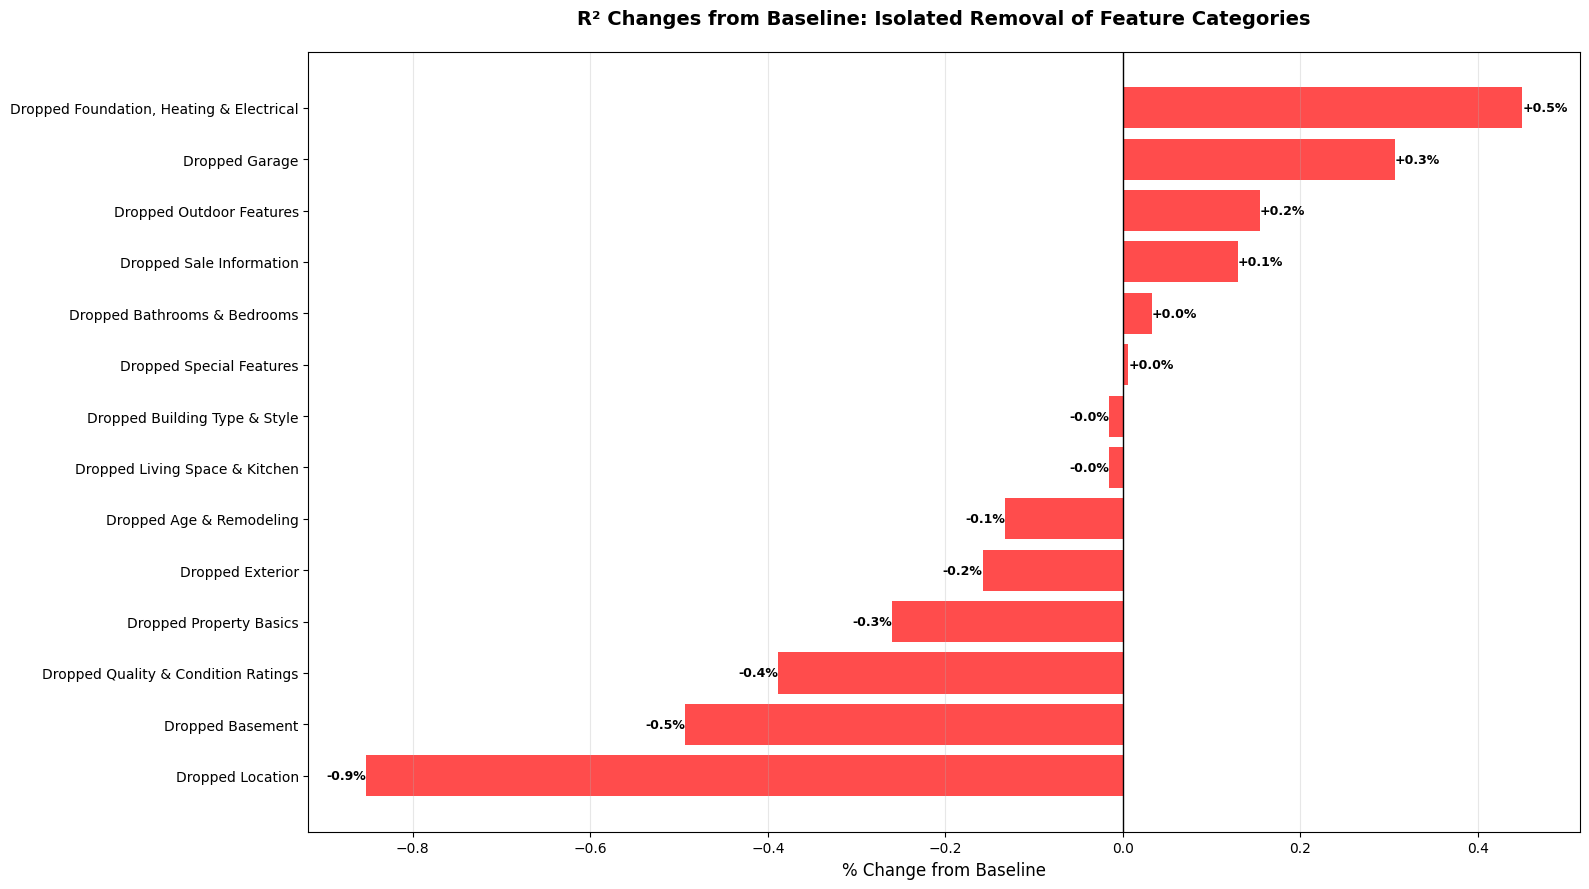

In [27]:
pct_changes_df = plot_ablation_changes(feature_results_df, "Isolated Removal of Feature Categories")
plt.show()

In [28]:
def ablation_study_incremental(X_train, X_test, y_train, y_test):
    results = {}
    best_params = {
        'learning_rate': 0.07001802283701665, 
        'max_depth': 3, 
        'n_estimators': 841}
    
    feature_categories = get_feature_categories(X_train.columns.tolist())
    
    category_order = [
        'Property Basics',
        'Quality & Condition Ratings',
        'Garage',
        'Living Space & Kitchen',
        'Special Features',
        'Building Type & Style',
        'Location',
        'Basement',
        'Outdoor Features',
        'Bathrooms & Bedrooms',
        'Age & Remodeling',
        'Foundation, Heating & Electrical',
        'Sale Information',
        'Exterior'
    ]
    
    features_to_include = []
    
    for i, category_name in enumerate(category_order):
        category_features = feature_categories[category_name]
        category_features_exist = [f for f in category_features if f in X_train.columns]
        features_to_include.extend(category_features_exist)
        
        print(f"\n[{i+1}/14] Training with {category_name} ({len(features_to_include)} total features)...")
        
        X_train_subset = X_train[features_to_include]
        X_test_subset = X_test[features_to_include]
        
        xgb = XGBRegressor(
            random_state=42,
            learning_rate=best_params["learning_rate"],
            max_depth=best_params["max_depth"],
            n_estimators=best_params["n_estimators"]
        )
        xgb.fit(X_train_subset, y_train)
        y_xgb_pred = xgb.predict(X_test_subset)
        
        results[f'Up to {category_name}'] = evaluate_model(y_test, y_xgb_pred)
    
    return results

In [29]:
incremental_results = ablation_study_incremental(X_train, X_test, y_train, y_test)
incremental_df = pd.DataFrame(incremental_results).T
incremental_df = incremental_df.sort_values('R²', ascending=False)
incremental_df


[1/14] Training with Property Basics (6 total features)...

[2/14] Training with Quality & Condition Ratings (12 total features)...

[3/14] Training with Garage (24 total features)...

[4/14] Training with Living Space & Kitchen (30 total features)...

[5/14] Training with Special Features (39 total features)...

[6/14] Training with Building Type & Style (66 total features)...

[7/14] Training with Location (124 total features)...

[8/14] Training with Basement (133 total features)...

[9/14] Training with Outdoor Features (145 total features)...

[10/14] Training with Bathrooms & Bedrooms (150 total features)...

[11/14] Training with Age & Remodeling (152 total features)...

[12/14] Training with Foundation, Heating & Electrical (166 total features)...

[13/14] Training with Sale Information (183 total features)...

[14/14] Training with Exterior (218 total features)...


,R²,RMSE,MAE,MAPE,RMSE%
Up to Basement,0.919401,24864.101673,15617.881836,9.293220,13.903001
Up to Sale Information,0.915692,25429.713644,15742.859375,9.400642,14.219269
Up to Age & Remodeling,0.915689,25430.214470,15605.169922,9.325809,14.219549
Up to Outdoor Features,0.914507,25607.790065,15749.479492,9.324161,14.318842
"Up to Foundation, Heating & Electrical",0.914481,25611.734810,16046.958984,9.531519,14.321048
Up to Exterior,0.914182,25656.457745,15856.741211,9.527260,14.346055
Up to Bathrooms & Bedrooms,0.912288,25938.040635,15932.585938,9.520168,14.503505
Up to Location,0.901765,27449.910747,17570.511719,10.522779,15.348881
Up to Living Space & Kitchen,0.888070,29300.857052,19060.000000,11.868472,16.383856
Up to Special Features,0.885195,29674.809250,19193.191406,11.995176,16.592955


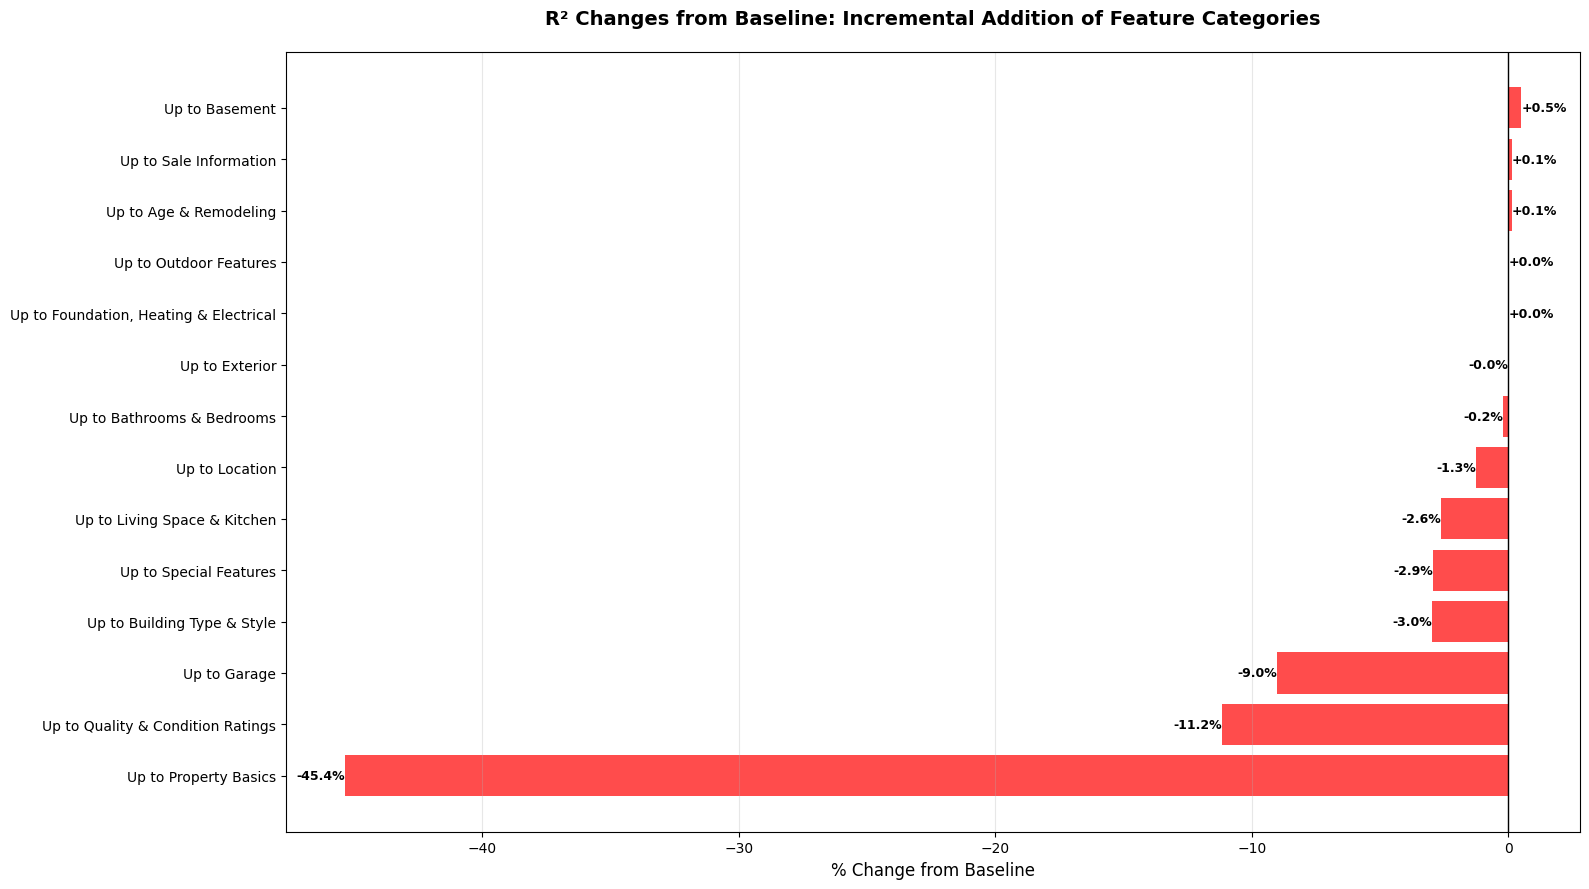

In [30]:
pct_changes_df = plot_ablation_changes(incremental_df, "Incremental Addition of Feature Categories")
plt.show()

In [31]:
def ablation_study_individual_features(X_train, X_test, y_train, y_test):
    results = {}
    best_params = {'learning_rate': 0.07001802283701665, 'max_depth': 3, 'n_estimators': 841}
    
    print("Calculating feature correlations with SalePrice...")
    correlations = {}
    for col in X_train.columns:
        if X_train[col].std() == 0:
            correlations[col] = 0
        else:
            corr = np.corrcoef(X_train[col], y_train)[0, 1]
            if np.isnan(corr):
                correlations[col] = 0
            else:
                correlations[col] = abs(corr)
    
    sorted_features = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
    
    print(f"\nTop 10 most correlated features:")
    for i, (feat, corr) in enumerate(sorted_features[:10]):
        print(f"  {i+1}. {feat}: {corr:.4f}")
    
    test_points = [5, 25, 50, 75, 100, 110, 120, 130, 140, 150, 200, len(X_train.columns)]
    test_points = [n for n in test_points if n <= len(X_train.columns)]
    
    for n in test_points:
        features_to_include = [feat for feat, _ in sorted_features[:n]]
        
        print(f"\nTraining with top {n} features...")
        
        X_train_subset = X_train[features_to_include]
        X_test_subset = X_test[features_to_include]
        
        xgb = XGBRegressor(
            random_state=42,
            learning_rate=best_params["learning_rate"],
            max_depth=best_params["max_depth"],
            n_estimators=best_params["n_estimators"]
        )
        xgb.fit(X_train_subset, y_train)
        y_xgb_pred = xgb.predict(X_test_subset)
        
        results[f'Top {n} features'] = evaluate_model(y_test, y_xgb_pred)
    
    return results

In [32]:
individual_results = ablation_study_individual_features(X_train, X_test, y_train, y_test)
individual_df = pd.DataFrame(individual_results).T
individual_df = individual_df.sort_values('R²', ascending=False)
individual_df

Calculating feature correlations with SalePrice...

Top 10 most correlated features:
  1. OverallQual: 0.7856
  2. GrLivArea: 0.6957
  3. ExterQual: 0.6655
  4. KitchenQual: 0.6607
  5. GarageCars: 0.6410
  6. GarageArea: 0.6241
  7. TotalBsmtSF: 0.5978
  8. BsmtQual: 0.5896
  9. 1stFlrSF: 0.5879
  10. FullBath: 0.5525

Training with top 5 features...

Training with top 25 features...

Training with top 50 features...

Training with top 75 features...

Training with top 100 features...

Training with top 110 features...

Training with top 120 features...

Training with top 130 features...

Training with top 140 features...

Training with top 150 features...

Training with top 200 features...

Training with top 219 features...


,R²,RMSE,MAE,MAPE,RMSE%
Top 75 features,0.916362,25328.520525,16523.003906,10.255433,14.162686
Top 140 features,0.916337,25332.239696,15811.371094,9.671993,14.164765
Top 130 features,0.915609,25442.264050,15893.702148,9.725781,14.226287
Top 120 features,0.914687,25580.769027,15834.829102,9.482401,14.303733
Top 150 features,0.914666,25583.904940,15778.208984,9.476307,14.305486
Top 200 features,0.914463,25614.413442,15751.838867,9.477887,14.322546
Top 219 features,0.914274,25642.678175,15798.379883,9.563046,14.338350
Top 100 features,0.913890,25699.978521,16422.849609,10.176222,14.370390
Top 110 features,0.912336,25930.902645,16515.832031,10.098078,14.499514
Top 50 features,0.904973,26997.927032,17880.740234,10.872087,15.096150


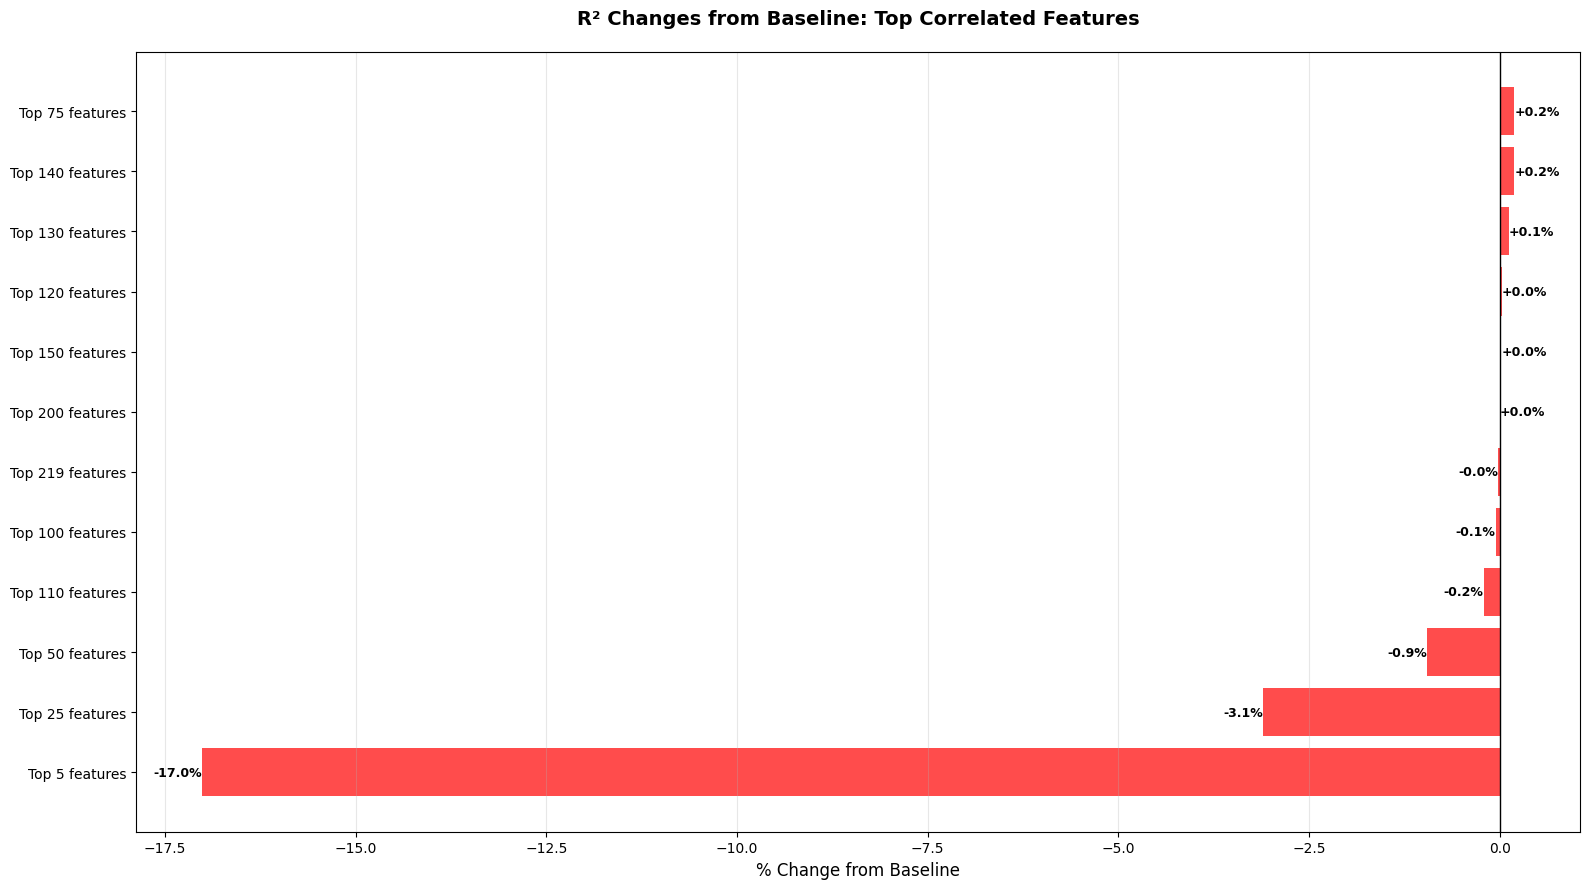

In [33]:
pct_changes_df = plot_ablation_changes(individual_df, "Top Correlated Features")
plt.show()

In [34]:
def test_xgboost_combinations(X_train, X_test, y_train, y_test):
    """
    Test various XGBoost hyperparameter and feature combinations.
    """
    results = {}
    
    best_params = {
        'learning_rate': 0.07001802283701665, 
        'max_depth': 3, 
        'n_estimators': 841
    }
    
    feature_categories = get_feature_categories(X_train.columns.tolist())
    
    print("Training optimized baseline model...")
    xgb_baseline = XGBRegressor(random_state=42, 
                               learning_rate=best_params["learning_rate"], 
                               max_depth=best_params["max_depth"], 
                               n_estimators=best_params["n_estimators"])
    xgb_baseline.fit(X_train, y_train)
    y_baseline_pred = xgb_baseline.predict(X_test)
    results['Baseline (Full Optimized)'] = evaluate_model(y_test, y_baseline_pred)
    
    print("\nTraining Max Depth=5...")
    xgb_md5 = XGBRegressor(random_state=42, 
                           learning_rate=best_params["learning_rate"], 
                           max_depth=5, 
                           n_estimators=best_params["n_estimators"])
    xgb_md5.fit(X_train, y_train)
    y_md5_pred = xgb_md5.predict(X_test)
    results['Max Depth=5'] = evaluate_model(y_test, y_md5_pred)
    
    print("\nTraining with dropped features (Foundation, Heating, Electrical)...")
    drop_prefixes = ['Foundation_', 'Heating_']
    cols_to_drop = [col for col in X_train.columns if any(col.startswith(p) for p in drop_prefixes)]
    cols_to_drop.extend([col for col in X_train.columns if col in ['CentralAir', 'Electrical']])
    X_train_dropped = X_train.drop(columns=cols_to_drop)
    X_test_dropped = X_test.drop(columns=cols_to_drop)
    
    xgb_dropped = XGBRegressor(random_state=42, 
                              learning_rate=best_params["learning_rate"], 
                              max_depth=best_params["max_depth"], 
                              n_estimators=best_params["n_estimators"])
    xgb_dropped.fit(X_train_dropped, y_train)
    y_dropped_pred = xgb_dropped.predict(X_test_dropped)
    results['Dropped Foundation/Heating/Electrical'] = evaluate_model(y_test, y_dropped_pred)
    
    print("\nTraining Max Depth=5 + Dropped Features...")
    xgb_combo = XGBRegressor(random_state=42, 
                            learning_rate=best_params["learning_rate"], 
                            max_depth=5, 
                            n_estimators=best_params["n_estimators"])
    xgb_combo.fit(X_train_dropped, y_train)
    y_combo_pred = xgb_combo.predict(X_test_dropped)
    results['Max Depth=5 + Dropped Features'] = evaluate_model(y_test, y_combo_pred)
    
    print("\nTraining Max Depth=5 + LR=0.05...")
    xgb_md5_lr = XGBRegressor(random_state=42, 
                             learning_rate=0.05, 
                             max_depth=5, 
                             n_estimators=best_params["n_estimators"])
    xgb_md5_lr.fit(X_train, y_train)
    y_md5_lr_pred = xgb_md5_lr.predict(X_test)
    results['Max Depth=5 + LR=0.05'] = evaluate_model(y_test, y_md5_lr_pred)
    
    print("\nTraining Max Depth=5 + LR=0.05 + n_estimators=700...")
    xgb_full_combo = XGBRegressor(random_state=42, 
                                 learning_rate=0.05, 
                                 max_depth=5, 
                                 n_estimators=700)
    xgb_full_combo.fit(X_train, y_train)
    y_full_combo_pred = xgb_full_combo.predict(X_test)
    results['Max Depth=5 + LR=0.05 + n_est=700'] = evaluate_model(y_test, y_full_combo_pred)
    
    print("\nTraining Max Depth=5 + LR=0.05 + Dropped Features...")
    xgb_ultimate = XGBRegressor(random_state=42, 
                               learning_rate=0.05, 
                               max_depth=5, 
                               n_estimators=best_params["n_estimators"])
    xgb_ultimate.fit(X_train_dropped, y_train)
    y_ultimate_pred = xgb_ultimate.predict(X_test_dropped)
    results['Max Depth=5 + LR=0.05 + Dropped Features'] = evaluate_model(y_test, y_ultimate_pred)
    
    print("\nTraining Max Depth=5 + LR=0.05 + n_est=700 + Dropped Features...")
    xgb_full_ultimate = XGBRegressor(random_state=42, 
                                    learning_rate=0.05, 
                                    max_depth=5, 
                                    n_estimators=700)
    xgb_full_ultimate.fit(X_train_dropped, y_train)
    y_full_ultimate_pred = xgb_full_ultimate.predict(X_test_dropped)
    results['Max Depth=5 + LR=0.05 + n_est=700 + Dropped'] = evaluate_model(y_test, y_full_ultimate_pred)
    
    results_df = pd.DataFrame(results).T
    results_df = results_df.sort_values(by='R²', ascending=False)

    basement_cats = ['Property Basics', 'Quality & Condition Ratings', 'Garage', 
                     'Living Space & Kitchen', 'Special Features', 'Building Type & Style',
                     'Location', 'Basement']
    basement_features = []
    for cat in basement_cats:
        basement_features.extend(feature_categories[cat])
    basement_features = [f for f in basement_features if f in X_train.columns]
    X_train_basement = X_train[basement_features]
    X_test_basement = X_test[basement_features]
    
    print(f"\nUp to Basement + Max Depth=5 ({len(basement_features)} features)...")
    xgb = XGBRegressor(random_state=42, learning_rate=best_params["learning_rate"], 
                       max_depth=5, n_estimators=best_params["n_estimators"])
    xgb.fit(X_train_basement, y_train)
    results['Up to Basement + Max Depth=5'] = evaluate_model(y_test, xgb.predict(X_test_basement))
    
    print(f"\nUp to Basement + Max Depth=5 + LR=0.05...")
    xgb = XGBRegressor(random_state=42, learning_rate=0.05, 
                       max_depth=5, n_estimators=best_params["n_estimators"])
    xgb.fit(X_train_basement, y_train)
    results['Up to Basement + Max Depth=5 + LR=0.05'] = evaluate_model(y_test, xgb.predict(X_test_basement))

    drop_prefixes = ['Foundation_', 'Heating_']
    basement_features_no_fhe = [f for f in basement_features if not any(f.startswith(p) for p in drop_prefixes)]
    basement_features_no_fhe = [f for f in basement_features_no_fhe if f not in ['CentralAir', 'Electrical']]
    
    X_train_basement_no_fhe = X_train[basement_features_no_fhe]
    X_test_basement_no_fhe = X_test[basement_features_no_fhe]
    
    print(f"\nUp to Basement + Dropped FHE ({len(basement_features_no_fhe)} features)...")
    xgb = XGBRegressor(random_state=42, learning_rate=best_params["learning_rate"], 
                       max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"])
    xgb.fit(X_train_basement_no_fhe, y_train)
    results['Up to Basement + Dropped FHE'] = evaluate_model(y_test, xgb.predict(X_test_basement_no_fhe))
    
    print(f"\nUp to Basement + Dropped FHE + Max Depth=5...")
    xgb = XGBRegressor(random_state=42, learning_rate=best_params["learning_rate"], 
                       max_depth=5, n_estimators=best_params["n_estimators"])
    xgb.fit(X_train_basement_no_fhe, y_train)
    results['Up to Basement + Dropped FHE + Max Depth=5'] = evaluate_model(y_test, xgb.predict(X_test_basement_no_fhe))
    
    print(f"\nUp to Basement + Dropped FHE + Max Depth=5 + LR=0.05...")
    xgb = XGBRegressor(random_state=42, learning_rate=0.05, 
                       max_depth=5, n_estimators=best_params["n_estimators"])
    xgb.fit(X_train_basement_no_fhe, y_train)
    results['Up to Basement + Dropped FHE + Max Depth=5 + LR=0.05'] = evaluate_model(y_test, xgb.predict(X_test_basement_no_fhe))
    
    results_df = pd.DataFrame(results).T
    results_df = results_df.sort_values(by='R²', ascending=False)
    
    return results_df

results_df = test_xgboost_combinations(X_train, X_test, y_train, y_test)

Training optimized baseline model...

Training Max Depth=5...

Training with dropped features (Foundation, Heating, Electrical)...

Training Max Depth=5 + Dropped Features...

Training Max Depth=5 + LR=0.05...

Training Max Depth=5 + LR=0.05 + n_estimators=700...

Training Max Depth=5 + LR=0.05 + Dropped Features...

Training Max Depth=5 + LR=0.05 + n_est=700 + Dropped Features...

Up to Basement + Max Depth=5 (133 features)...

Up to Basement + Max Depth=5 + LR=0.05...

Up to Basement + Dropped FHE (133 features)...

Up to Basement + Dropped FHE + Max Depth=5...

Up to Basement + Dropped FHE + Max Depth=5 + LR=0.05...


In [35]:
results_df

,R²,RMSE,MAE,MAPE,RMSE%
Max Depth=5 + Dropped Features,0.922885,24320.724989,15310.772461,9.453469,13.599167
Up to Basement + Dropped FHE + Max Depth=5,0.922266,24418.137521,15685.802734,9.423557,13.653636
Up to Basement + Max Depth=5,0.922266,24418.137521,15685.802734,9.423557,13.653636
Max Depth=5 + LR=0.05 + n_est=700,0.921750,24499.009613,15396.294922,9.448165,13.698857
Up to Basement + Max Depth=5 + LR=0.05,0.921735,24501.316210,15655.633789,9.402528,13.700147
Up to Basement + Dropped FHE + Max Depth=5 + LR=0.05,0.921735,24501.316210,15655.633789,9.402528,13.700147
Max Depth=5 + LR=0.05,0.921649,24514.913665,15409.347656,9.456539,13.707750
Max Depth=5,0.921219,24581.982345,15512.113281,9.597627,13.745252
Max Depth=5 + LR=0.05 + Dropped Features,0.920896,24632.335171,15329.732422,9.404573,13.773407
Max Depth=5 + LR=0.05 + n_est=700 + Dropped,0.920869,24636.501050,15319.688477,9.392076,13.775736


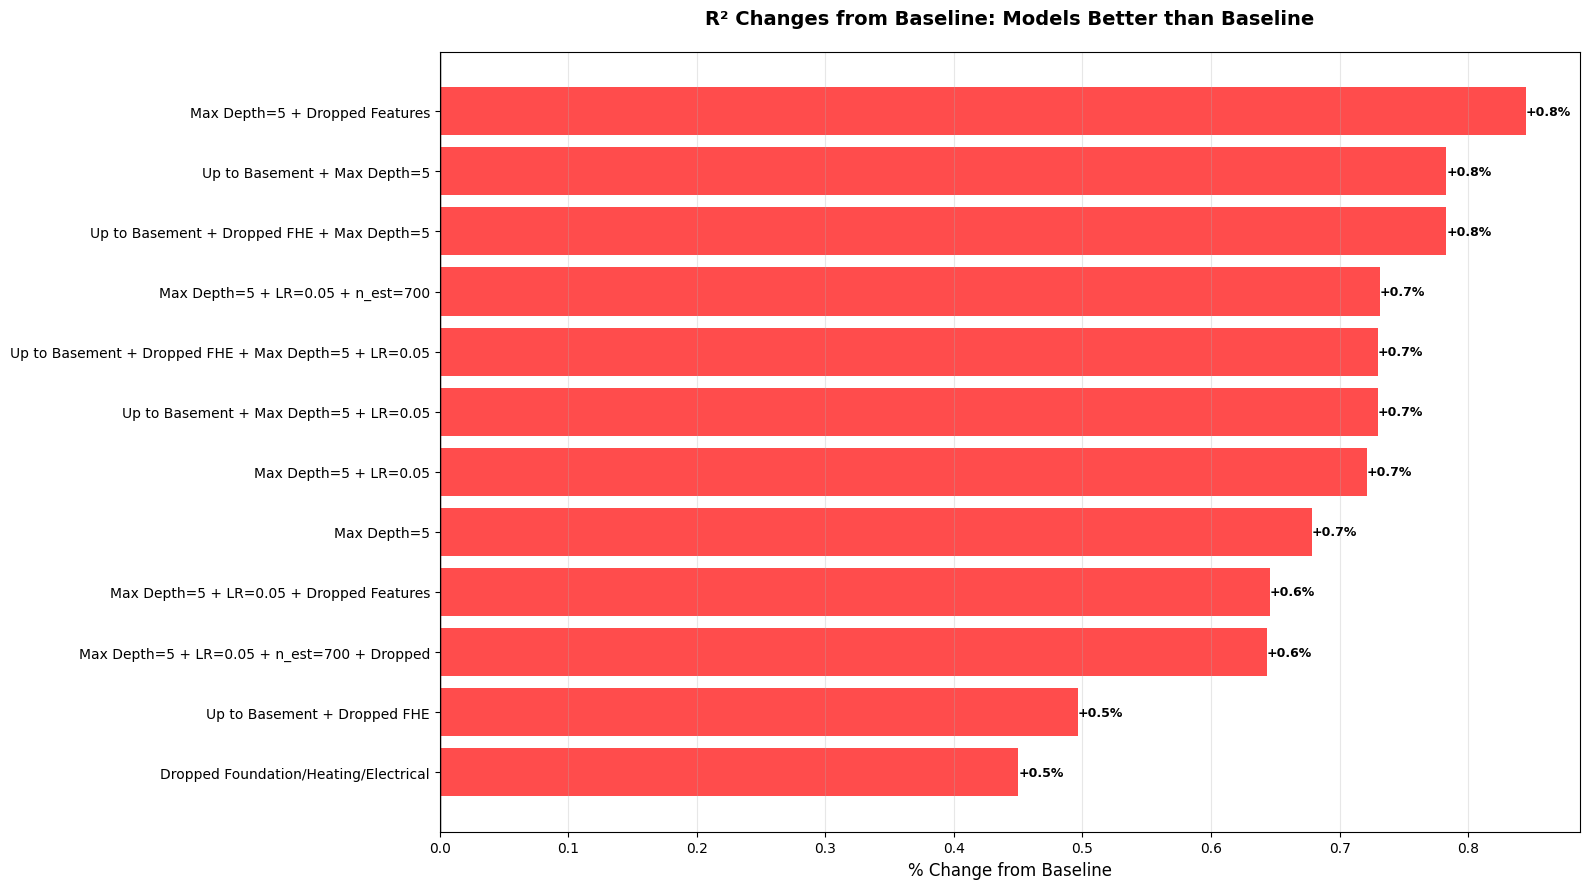

In [36]:
pct_changes_df = plot_ablation_changes(results_df, "Models Better than Baseline")
plt.show()

In [37]:
best_combo = results_df.loc['Max Depth=5 + Dropped Features']
print(f"\nXGB w/ Max Depth=5 + Dropped Foundation/Heating/Electrical")
print(f"R²: {best_combo['R²']:.6f}")
print(f"RMSE: ${best_combo['RMSE']:,.2f}")
print(f"MAE: ${best_combo['MAE']:,.2f}")
print(f"MAPE: {best_combo['MAPE']:.2f}%")
print(f"RMSE%: {best_combo['RMSE%']:.2f}%")


XGB w/ Max Depth=5 + Dropped Foundation/Heating/Electrical
R²: 0.922885
RMSE: $24,320.72
MAE: $15,310.77
MAPE: 9.45%
RMSE%: 13.60%
